# Introduction
skANI provides fast, accurate, pairwise genome similarity estimates suitable for large bacterial datasets to help detect closely related strains or species clusters, even among hundreds of genomes.
the objective is to confirm which genomes are closely related at the species or strain level.

- Load skANI edge list – read pairwise ANI values between bacterial genomes.
- Load GTDB-Tk classification – get standardized taxonomy for each genome.
- Generate species-level names – create Genus species labels for readability.
- Subset skANI data – keep only rows where Ref/Query genomes have taxonomy.
- Map taxon names – add Ref_taxon and Query_taxon for labeling.
- Plot clustered heatmap – visualize genome similarity clusters with taxon labels.



In [1]:
import pandas as pd
import qiime2 as q2
%matplotlib inline
from qiime2 import Visualization

data_dir = 'data/processed/05_skANI'

## skANI edge list

In [2]:
import pandas as pd
import os

file_path = "data/processed/05_skANI/skANI_Results/bacteria_skani_ani_edge_list.txt"

# Read only the relevant columns (first 7: skip any extra trailing columns)
df_skani = pd.read_csv(file_path, sep='\t', usecols=range(7))

# Generate Ref_name and Query_name from filenames
df_skani['Ref_name'] = df_skani['Ref_file'].apply(lambda x: os.path.basename(x).replace('.fasta',''))
df_skani['Query_name'] = df_skani['Query_file'].apply(lambda x: os.path.basename(x).replace('.fasta',''))

df_skani.head(3)

,Ref_file,Query_file,ANI,Align_fraction_ref,Align_fraction_query,Ref_name,Query_name
0,/cluster/scratch/emotta/skANI_input/mags_filte...,/cluster/scratch/emotta/skANI_input/mags_filte...,90.85,57.17,67.75,009d5f9a-be92-4328-b5ad-68d282a94e3b,4ed034a2-19c0-45b7-9043-d2b9837f89f9
1,/cluster/scratch/emotta/skANI_input/mags_filte...,/cluster/scratch/emotta/skANI_input/mags_filte...,90.85,61.03,63.74,009d5f9a-be92-4328-b5ad-68d282a94e3b,537164fe-2e46-4ebb-8495-a1dfe6dbd1f2
2,/cluster/scratch/emotta/skANI_input/mags_filte...,/cluster/scratch/emotta/skANI_input/mags_filte...,98.96,31.19,36.57,4ea168ad-7af1-47d3-8401-7786efffa269,8c0bb3e7-e2a9-4ecc-8b39-dc4d15a33af0


## GTDBTK taxonomy

In [3]:
import pandas as pd

# Read taxonomy file
taxonomy = pd.read_csv('data/processed/05_skANI/gtdbtk.bac120.ani_summary.tsv', sep='\t')
taxonomy.head(3)

,user_genome,reference_genome,skani_ani,skani_af,reference_taxonomy,"other_related_references(genome_id,species_name,radius,ANI,AF)"
0,01b54364-1bbb-43e7-9366-a931641ff6cd,GCF_001437285.1,98.78,0.7899,d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...,NaN
1,01bfbb6d-8bcb-40fc-b639-b0c66897a07b,GCF_000963945.1,96.30,0.8917,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,NaN
2,01c257e7-cc4e-41ba-9f3d-bdfc0a851d09,GCF_000423785.1,98.91,0.8750,d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...,"GCF_003795125.1, s__Tetragenococcus osmophilus..."


In [4]:

# Extract species from the taxonomy string
taxonomy['taxon'] = taxonomy['reference_taxonomy'].apply(
    lambda x: next((part.replace('s__', '') for part in x.split(';') if part.startswith('s__')), '')
)

# Show the first few rows
print(taxonomy[['reference_taxonomy', 'taxon']].head(3))


                                  reference_taxonomy  \
0  d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...   
1  d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...   
2  d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...   

                        taxon  
0     Pediococcus pentosaceus  
1   Acetobacter indonesiensis  
2  Tetragenococcus muriaticus  


## Add taxon info to the skANI matrix

In [5]:
import pandas as pd

# Assuming df_skani and taxonomy are already loaded
# taxonomy has columns: 'user_genome' (genome names) and 'taxon' (Genus species)

# Create a mapping from genome name to taxon
genome_to_taxon = dict(zip(taxonomy['user_genome'], taxonomy['taxon']))

# Map Ref_name and Query_name to taxon
df_skani['Ref_taxon'] = df_skani['Ref_name'].map(genome_to_taxon)
df_skani['Query_taxon'] = df_skani['Query_name'].map(genome_to_taxon)

# Drop rows where either Ref_taxon or Query_taxon is NaN
df_skani = df_skani.dropna(subset=['Ref_taxon', 'Query_taxon'])
df_skani.reset_index(drop=True, inplace=True)

# Check result
print(df_skani[['Ref_name', 'Ref_taxon', 'Query_name', 'Query_taxon']].head(5))


                               Ref_name                      Ref_taxon  \
0  4ea168ad-7af1-47d3-8401-7786efffa269  Lactiplantibacillus plantarum   
1  4ea168ad-7af1-47d3-8401-7786efffa269  Lactiplantibacillus plantarum   
2  4ea168ad-7af1-47d3-8401-7786efffa269  Lactiplantibacillus plantarum   
3  5ea3c25e-ce0f-4c72-b11a-89b2c7beccd0   Peptostreptococcus russellii   
4  64a87915-b807-431a-baf2-50d3767e4e4d           Lactococcus garvieae   

                             Query_name                    Query_taxon  
0  8c0bb3e7-e2a9-4ecc-8b39-dc4d15a33af0  Lactiplantibacillus plantarum  
1  bae46a8e-75cc-486a-835c-98780e484024  Lactiplantibacillus plantarum  
2  8590354c-5834-4514-8f5b-d7756ba7d644  Lactiplantibacillus plantarum  
3  c424280d-49fd-41f0-ba5b-733128b0c776   Peptostreptococcus russellii  
4  eb5f1c06-8305-43e2-a47b-b2e72f0e1297        Lactococcus formosensis  


## skani matrix

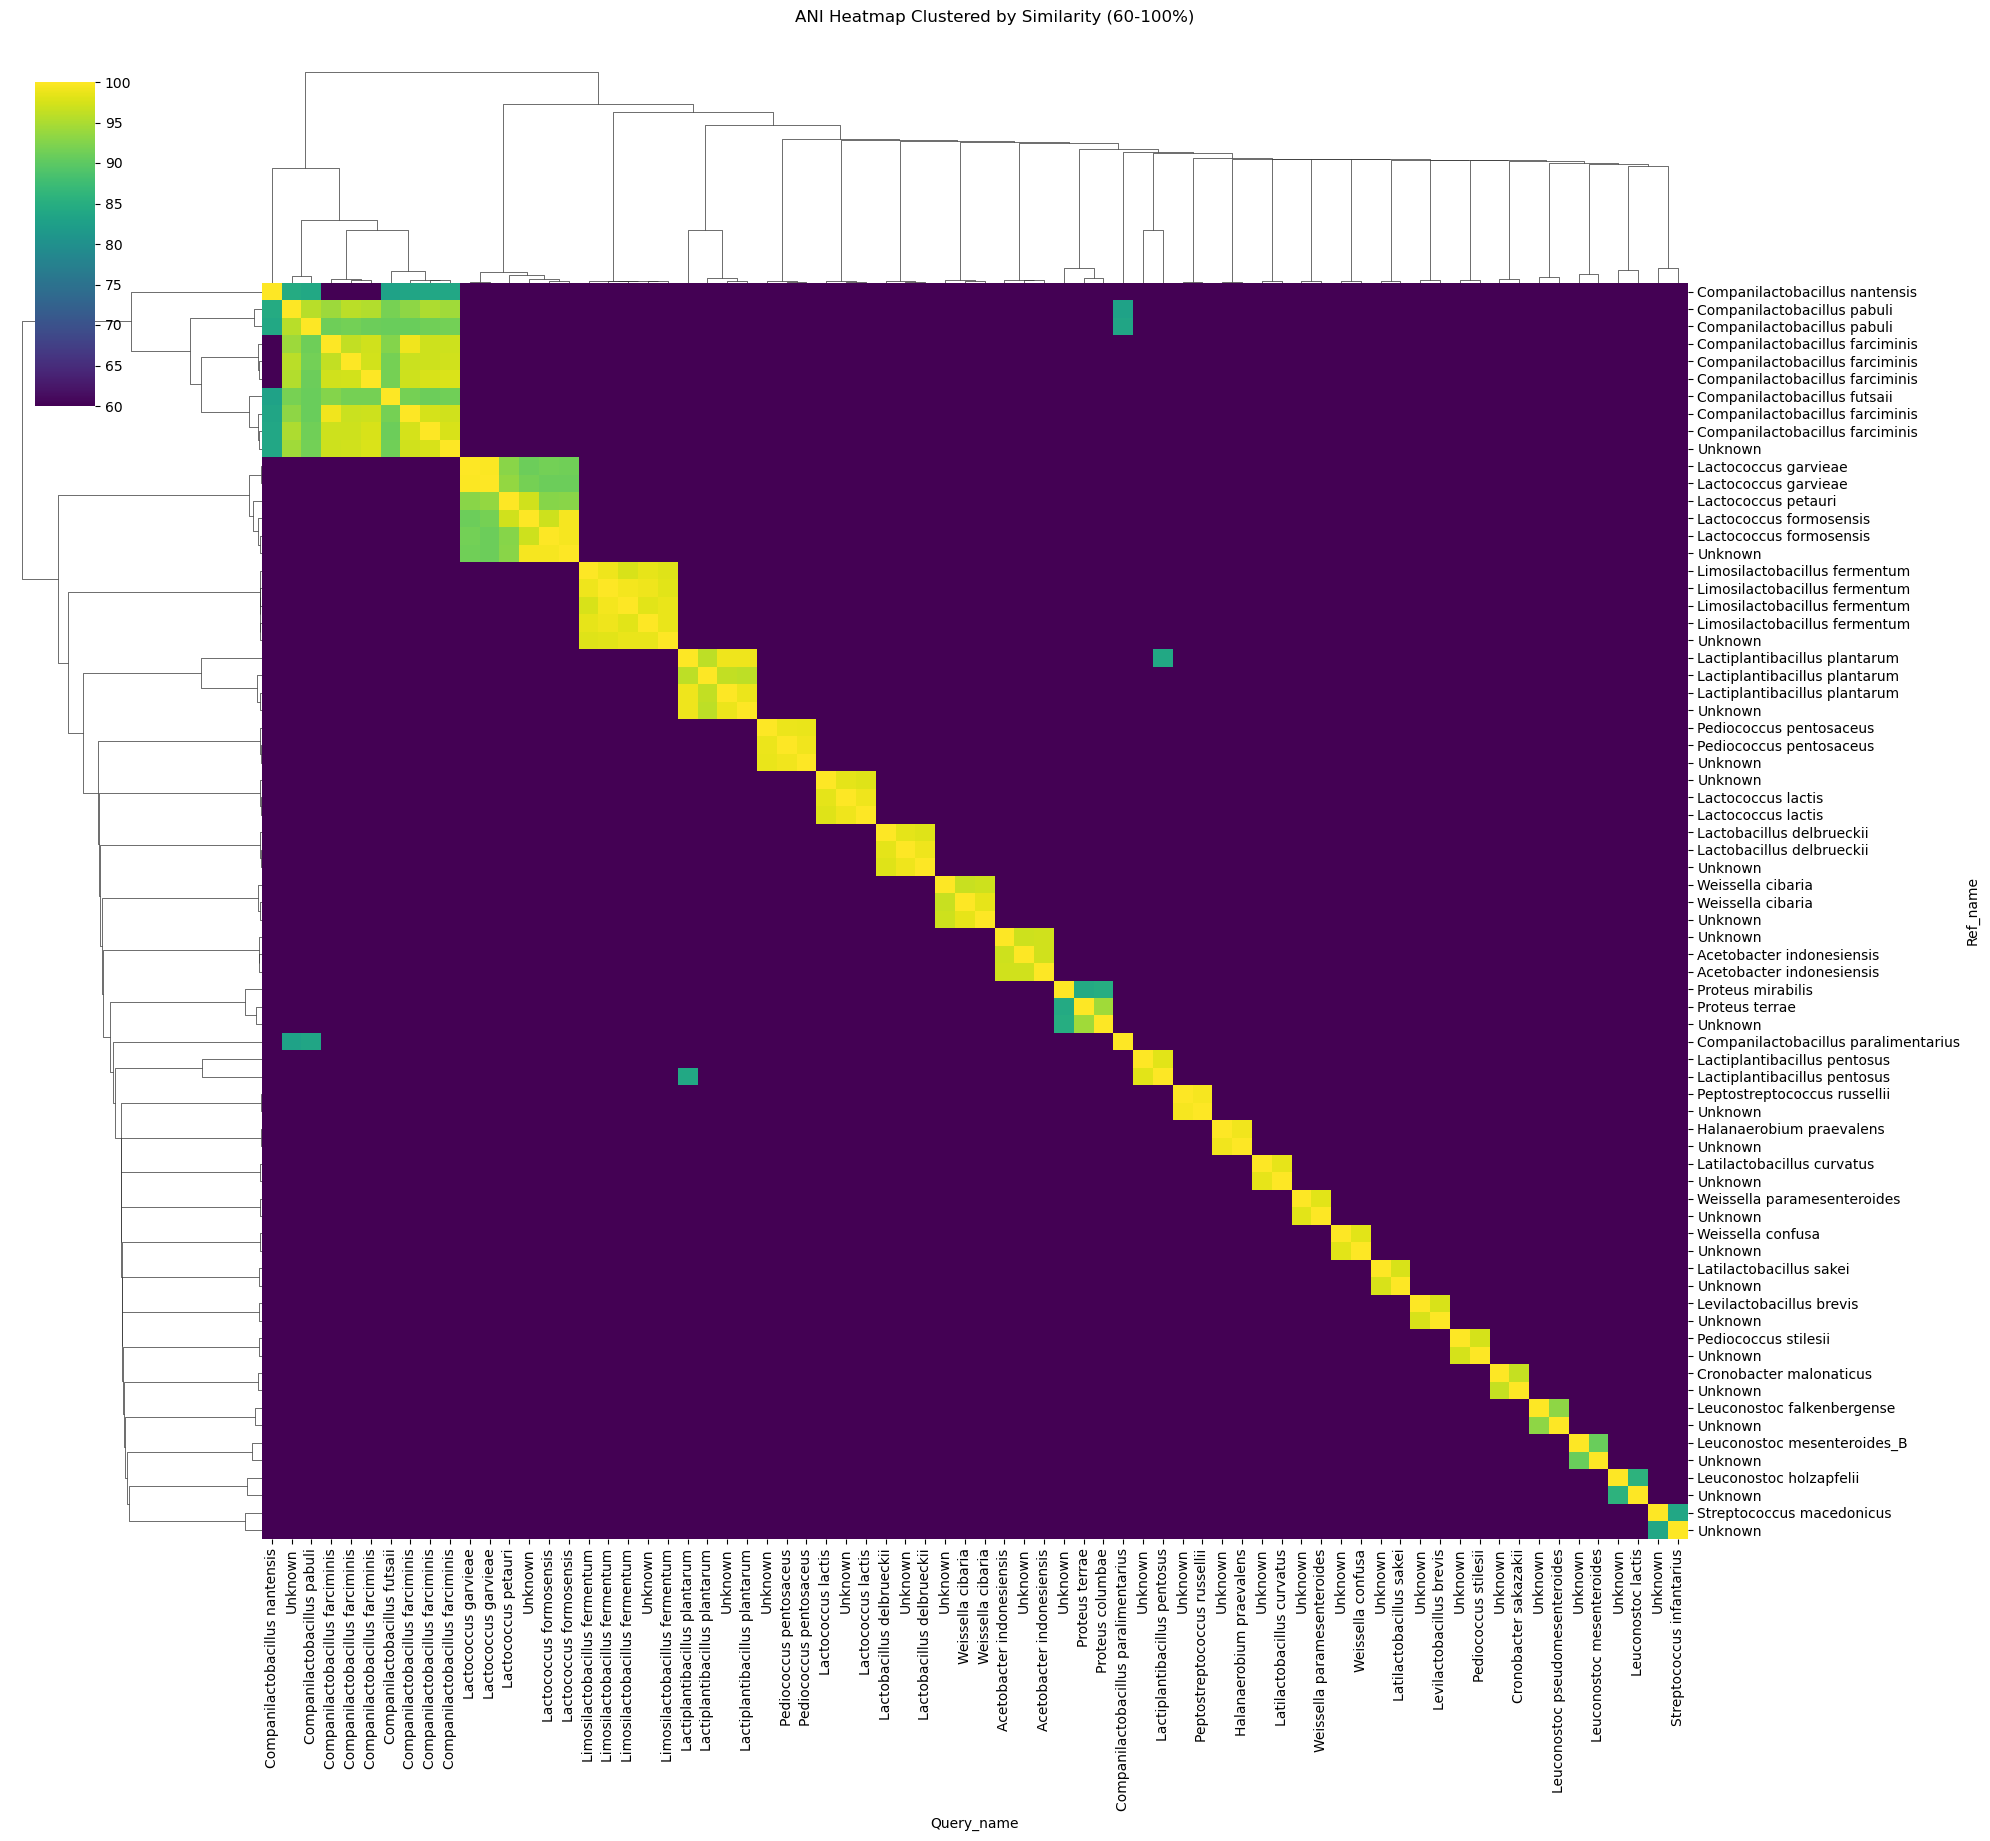

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Keep necessary columns
df_skani_sub = df_skani[['Ref_name', 'Query_name', 'ANI', 'Ref_taxon', 'Query_taxon']]

# Handle duplicates by averaging ANI for exact genome pairs
df_skani_sub = df_skani_sub.groupby(['Ref_name', 'Query_name', 'Ref_taxon', 'Query_taxon'], as_index=False)['ANI'].mean()

# Make the matrix symmetric
df_symmetric = pd.concat([
    df_skani_sub,
    df_skani_sub.rename(columns={
        'Ref_name': 'Query_name',
        'Query_name': 'Ref_name',
        'Ref_taxon': 'Query_taxon',
        'Query_taxon': 'Ref_taxon'
    })
])

# Pivot using genome UUIDs
heatmap_data = df_symmetric.pivot(index='Ref_name', columns='Query_name', values='ANI')

# Fill missing values with 0 and diagonal with 100%
heatmap_data = heatmap_data.fillna(0)
np.fill_diagonal(heatmap_data.values, 100.0)

# Map genome UUID → taxon for tick labels
ref_taxon_dict = df_skani.set_index('Ref_name')['Ref_taxon'].to_dict()
query_taxon_dict = df_skani.set_index('Query_name')['Query_taxon'].to_dict()

ref_labels = [ref_taxon_dict.get(uuid, 'Unknown') for uuid in heatmap_data.index]
query_labels = [query_taxon_dict.get(uuid, 'Unknown') for uuid in heatmap_data.columns]

# Clustermap with bigger squares
sns.clustermap(
    heatmap_data,
    cmap='viridis',
    row_cluster=True,
    col_cluster=True,
    figsize=(20, 18),   # increased figure size
    xticklabels=query_labels,
    yticklabels=ref_labels,
    vmin=60,
    vmax=100,
    dendrogram_ratio=(0.15, 0.15),  # make dendrograms slightly smaller
    cbar_pos=(0.02, 0.8, 0.03, 0.18)  # optional: move colorbar to reduce overlap
)

plt.suptitle('ANI Heatmap Clustered by Similarity (60-100%)', y=1.02)
plt.savefig("data/Visualizations/skANIspecies.svg", transparent=True)
plt.show()
